In [26]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [85]:
import torch

with open("../sv_system/embeddings/voxc2_fbank64_voxc2untied_embeds/plda_train/mean.vec", "r") as f:
    voxc2_si_mean = np.array(list(f.read().split(' ')[2:-1]), dtype=np.float32)
    voxc2_si_mean = torch.from_numpy(voxc2_si_mean).unsqueeze(0)

In [86]:
trial = pd.read_csv("../sv_system/datasets/voxceleb1/dataframes/voxc1_sv_trial.csv")

In [87]:
from utils import key2df 
import torch
voxc1_si_key = pickle.load(open("../sv_system/embeddings/voxc1_fbank64_voxc2untied_embeds/si_keys.pkl", "rb"))
voxc1_si_df = key2df(voxc1_si_key)
voxc1_si_embeds = np.load("../sv_system/embeddings/voxc1_fbank64_voxc2untied_embeds/si_embeds.npy")
voxc1_si_embeds = torch.from_numpy(voxc1_si_embeds) - voxc2_si_mean

In [88]:
voxc1_sv_key = pickle.load(open("../sv_system/embeddings/voxc1_fbank64_voxc2untied_embeds/sv_keys.pkl", "rb"))
voxc1_sv_df = key2df(voxc1_sv_key)
voxc1_sv_embeds = np.load("../sv_system/embeddings/voxc1_fbank64_voxc2untied_embeds/sv_embeds.npy")
voxc1_sv_embeds = torch.from_numpy(voxc1_sv_embeds) - voxc2_si_mean

In [89]:
cohort_set = voxc1_si_df.groupby("spk", group_keys=False).apply(lambda x: x.sample(n=5))
cohort_embeds = voxc1_si_embeds[cohort_set.idx]

In [90]:
from torch.nn.functional import cosine_similarity as cosine
sv_cohort_score = cosine(voxc1_sv_embeds.unsqueeze(1), cohort_embeds.unsqueeze(0), dim=2)

In [91]:
sv_cohort_score = sv_cohort_score.sort(dim=1, descending=True)[0]

In [92]:
sv_cohort_mu = sv_cohort_score[:, :1000].mean(1)
sv_cohort_std = sv_cohort_score[:, :1000].std(1)

In [93]:
cos_score = cosine(voxc1_sv_embeds[trial.enroll_idx], voxc1_sv_embeds[trial.test_idx], dim=1)

In [94]:
z_score = (cos_score - sv_cohort_mu[trial.enroll_idx]) / sv_cohort_std[trial.enroll_idx]

In [95]:
t_score = (cos_score - sv_cohort_mu[trial.test_idx]) / sv_cohort_std[trial.test_idx]

In [96]:
s_score = (z_score + t_score)/2

In [97]:
from utils import compute_eer
cos_eer = compute_eer(cos_score.numpy()[trial.label==1], cos_score.numpy()[trial.label==0])
z_eer = compute_eer(z_score.numpy()[trial.label==1], z_score.numpy()[trial.label==0])
t_eer = compute_eer(t_score.numpy()[trial.label==1], t_score.numpy()[trial.label==0])
s_eer = compute_eer(s_score.numpy()[trial.label==1], s_score.numpy()[trial.label==0])

In [98]:
cos_eer, z_eer, t_eer, s_eer

(0.0295864262990456,
 0.029957582184517495,
 0.02953340402969251,
 0.028738069989395546)

In [99]:
labels = trial.label
pos_score_idx = np.nonzero(labels)[0]
neg_score_idx = np.nonzero(1-labels)[0]

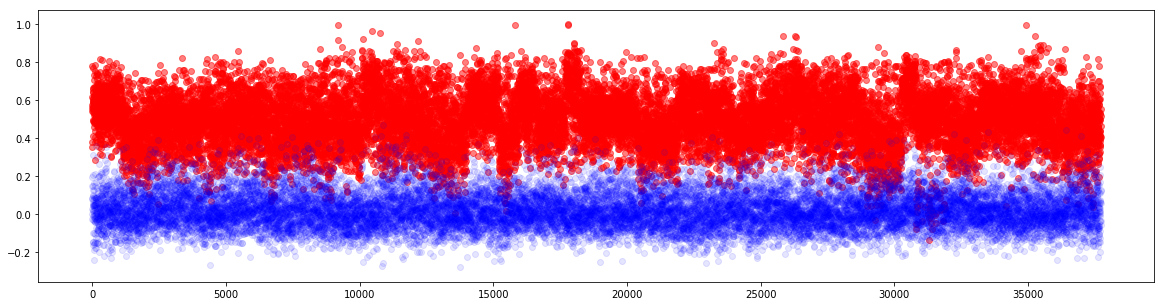

In [100]:
plt.figure(figsize=(20,5))
# plt.plot(thresholds, color='k')
# plt.scatter(np.arange(len(cos_score)), cos_score, alpha=0.5)
plt.scatter(pos_score_idx, cos_score[pos_score_idx], alpha=0.5, color='r')
plt.scatter(neg_score_idx, cos_score[neg_score_idx], alpha=0.1, color='b')
# plt.ylim([0.2, 0.4])
plt.show()

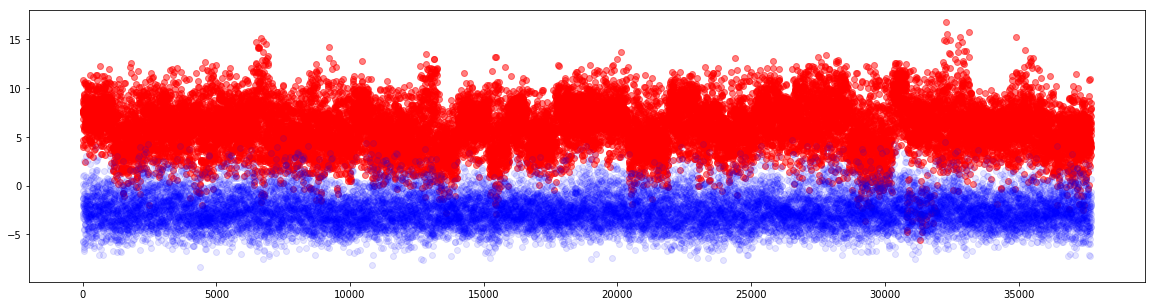

In [101]:
plt.figure(figsize=(20,5))
# plt.plot(thresholds, color='k')
# plt.scatter(np.arange(len(s_score)), s_score, alpha=0.5)
plt.scatter(pos_score_idx, s_score[pos_score_idx], alpha=0.5, color='r')
plt.scatter(neg_score_idx, s_score[neg_score_idx], alpha=0.1, color='b')
# plt.ylim([0, 5])
plt.show()